## SLIM Pickins GUI: An Interactive Circuit Layout Tool for Planar Traveling Wave Ion Guides
* BHC 01.Feb.2022
* [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)

### NOTE THIS IS FOR THE GUI ONLY
* A greater number of options are supported by the manual layout tool at the sacrifice of easy of use. 

### Objective: Simplify the layout of SLIM boards and facilitate rapid prototyping.  This script can aid in the export of exact SLIM monomer locations that can be imported into KiCad or another suitable PCB design tool. 

### How to use?

The general strategy is to layout a SLIM path similar to the path that a rudimentary game character might behave moving through a maze. A centipede character is a good example? 

![Path Track](https://1.bp.blogspot.com/-VgBXjKlVJds/XzB6hr2qfKI/AAAAAAAAZmI/XzzPcgEnl0Imw70Rn0xKA7ojnxBt7FHEQCLcBGAsYHQ/s384/centipede_path_size2.gif)

There are two key components to laying out a track. The starting direction decides which direction the paths are laid out and the track string details the absolute track path.  For example a starting direction of 'E' corresponds to an SLIM path with a starting direction of East for the ions. With this starting position and a path layout of "FRLF" would create a path that corresponds to a track that is ESEE (East, South, East, East). Using this strategy it is possible to layout the individual components of the SLIM board. It is recognized that multiple different types of SLIM paths may comprise a full board and this set of scripts allows for each section to be built independently.  

In addition to being a graphical tool, the center locations of each monomer are stored in a python dictionary that is exported to a json file.  This json file, when paired with a script for KiCad, can be used to explicitly layout the board. Be mindful that you understand that two different monomer footprints are needed in the PCB software. One with a guard above the tracks and one with the guard below the tracks. This is to ensure that guards do not conflict when turning different direction. 

<img src="BottomGuard.png" width=300 height=300 />
<img src="TopGuard.png" width=300 height=300 />
<!-- ![Bottom Guard](BottomGuard.png)
![Top Guard](TopGuard.png) -->

### Remember, above all, this is an *iterative* process.  The input parameters are the total length of a SLIM monomer and the relative centroid values following a turn. It is incumbent upon the user to move through the process in a deliberate manner and don't be afraid to revise previous track layouts to ensure they mesh. A final board review is always necessary.  Known conflicts with guard overlaps occur when different, indepdendent paths are overlaid upon each other to make a full board. 

<img src="TurnLayout.png" width=500 height=500 />

### Import Modules

In [1]:
import sys
import param
import logging
import panel as pn
import numpy as np
import pandas as pd
import json
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle, Circle

In [2]:
# pn.extension()#sizing_mode = 'stretch_both')
# pn.extension()

css = '''
.bk.cont {
    border:dashed 1px black;
    overflow-y:scroll;
    overflow-x:hidden;
}
'''

pn.extension(raw_css=[css])

## Key SLIM Layout Variables

In [3]:
trackLen = 360 #width in mils
aOffset = 295.5 #turn offset A
bOffset = 64.5 #turn offset B

### Variables for Plotting

In [4]:
#Everthing below is related to plotting
trackMod = 25 #used for plotting to show the individual electrode footprints
guardOffset = trackLen/8*3 #used for plotting to simulate whether the guard should exist on the "top" or "bottom" relative to the electrodes
masterMS = 2 #marker size
masterFigSize = (4.5, 4.5)
upColor = '#2ca25f'#'r'
downColor = '#2c7fb8'#'b'
rightColor = '#de2d26'#'g'
leftColor = '#756bb1'#'#fecc5c'#k'

### Functions to Support Track Plotting

In [5]:
def turnLogic(curLogic, nextLogic, curX, curY, aOffset = aOffset, bOffset = bOffset, trackLen = trackLen):
    '''
    When factoring in the current and next direction into account, determine the orientation of the current monomer. 
    '''
    if curLogic == 'N':
        if nextLogic == 'E': #right turn
            newX = curX + bOffset
            newY = curY + aOffset
        if nextLogic == 'W': #left turn
            newX = curX + -1*bOffset
            newY = curY + aOffset

    if curLogic == 'E':
        if nextLogic == 'S': #right turn
            newX = curX + aOffset
            newY = curY + -1*bOffset
        if nextLogic == 'N': #left turn
            newX = curX + aOffset
            newY = curY + bOffset            

    if curLogic == 'S':
        if nextLogic == 'E': #right turn
            newX = curX + bOffset
            newY = curY + -1*aOffset
        if nextLogic == 'W': #left turn
            newX = curX + -1*bOffset
            newY = curY + -1*aOffset                

    if curLogic == 'W':
        if nextLogic == 'N': #right turn
            newX = curX + -1*aOffset
            newY = curY + bOffset
        if nextLogic == 'S': #left turn
            newX = curX + -1*aOffset
            newY = curY + -1*bOffset 
            
    return newX, newY

In [6]:
'''
https://stackoverflow.com/questions/59108529/how-to-move-along-a-2d-grid-in-python
This class serves to navigate the path. Instead of a standard step of one, 
the class was modified to allow for the step size to move by the track length.
'''

class Point:
    def __init__(self, x: int, y:int , facing: str, stepMod = trackLen):
        self.x = x
        self.y = y
        self.stepMod = stepMod #BHC
        self.facing = facing
        self.lastFacing = facing

    def left(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'W':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'S':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)            
            
        else:
            self.facing = 'N'

    def right(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'S':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)

        elif self.facing == 'W':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
            
        else:
            self.facing = 'N'

    def forward(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.y += 1*self.stepMod
        elif self.facing == 'E':
            self.x += 1*self.stepMod
        elif self.facing == 'S':
            self.y -= 1*self.stepMod
        else:
            self.x -= 1*self.stepMod    

    def __repr__(self):
        return f"(x,y) = {(self.x,self.y)} \t{x} \t last direction = {self.lastFacing} \t direction = {self.facing} "

In [7]:
def guardFlipLogic(lastDir, currentDir):
    '''
    This is for plotting only and determines where to put the guard. 
    The actual layout logic is in "footprintLogic"
    '''
    flipLogic = True
    if lastDir == 'W':
        if currentDir == 'N':
            flipLogic = False
        if currentDir == 'S':
            flipLogic = False
        if currentDir == 'W':
            flipLogic = False            
    if lastDir == 'S':
        if currentDir == 'W':
            flipLogic = False
        if currentDir == 'E':
            flipLogic = False
    return flipLogic

In [8]:
def getLayoutParam(trackString, initDirection = 'E', curX = 0, curY = 0, sectionName = 'SLIM Track', markerStyle = 'o'):
    '''
    Link the core functions together to create a dictionary containin the necessary information for plotting
    and PCB layout. 
    '''
    
    startPos = initDirection
        
    #handle whether the line drawn should be horizontal or not
    hBool = True
    if startPos == 'N' or startPos == 'S':
        hBool = not hBool

    trackDict = {}        
    trackDict['origin'] = [curX, curY]
    
    
    curPoint = Point(curX,curY,startPos)
    xyPos = []
    boolList = []
    
    curAngleList = []

    curDirList = []
    for i,x in enumerate(trackString):
        if x == 'L':
            curPoint.left()
            hBool = not hBool
            boolList.append(hBool)
        elif x == 'R':
            curPoint.right()
            hBool = not hBool
            boolList.append(hBool)        
        else:
            curPoint.forward()
            boolList.append(hBool)

        xyPos.append([curPoint.x, curPoint.y])
        curDirList.append(curPoint.facing)

    #handle guards and their orientation
    guardFlipList = [True] #list of booleans, whether the guard is flipped or not depends upon the prior position
    currentDir = curDirList[0]
    for i,direction in enumerate(curDirList):
        if i == 0:
            currentDir = direction
        else:
            lastDir = currentDir
            currentDir = direction
            flipLogic = guardFlipLogic(lastDir, currentDir)
            guardFlipList.append(flipLogic)
    #         print(lastDir, currentDir)    
    
    trackDict['section name'] = sectionName
    trackDict['marker style'] = markerStyle
    trackDict['guard logic'] = guardFlipList
    trackDict['line bool'] = boolList
    trackDict['xy'] = xyPos
    trackDict['direction'] = curDirList


    return trackDict
    

In [9]:
def plotMonomer(mplAx, curX, curY, trackLen = trackLen, trackOffset = trackMod, guardOffset = guardOffset, showGuard = True, offsetBool = True, hBool = False, curColor = 'r', ms = 4, markerStyle = 'o', alphaLevelMain = 0.75, alphaLevelLo = 0.5, linewidth = 1.0):
    '''
    Requires:
        a matplotlib axis as an input
        X location
        Y location
        track length
        offset for plotting guard
        hBool is a boolean that determines whether the track is horizontal or vertical in nature
        Additoinal Plotting Parameters
    '''
    halfTrack = (trackLen/2)-trackOffset
    if hBool:
        if showGuard:
            if offsetBool:
                mplAx.hlines(curY+guardOffset, curX-halfTrack, curX+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
            else:
                mplAx.hlines(curY-guardOffset, curX-halfTrack, curX+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
        retLine = mplAx.hlines(curY, curX-halfTrack, curX+halfTrack, color = curColor, alpha = alphaLevelMain, linewidth = linewidth)
        mplAx.plot(curX, curY, markerStyle, color = curColor, mfc = 'w', markersize = ms, alpha = alphaLevelMain)
        return retLine
    else:
        if showGuard:
            if offsetBool:
                mplAx.vlines(curX+guardOffset, curY-halfTrack, curY+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
            else:
                mplAx.vlines(curX-guardOffset, curY-halfTrack, curY+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
        retLine = mplAx.vlines(curX, curY-halfTrack, curY+halfTrack, color = curColor, alpha = alphaLevelMain, linewidth = linewidth)
        mplAx.plot(curX, curY, markerStyle, color = curColor, mfc = 'w', markersize = ms, alpha = alphaLevelMain)
        return retLine
    

In [10]:
def colorLogic(curDirection, upColor = upColor, downColor = downColor, leftColor = leftColor, rightColor = rightColor):
    '''
    A default logic to determine the color you want for the different plotting. Default colors are specified above
    '''
    retColor = 'k'
    if curDirection == 'N':
        retColor = upColor
    if curDirection == 'S':
        retColor = downColor

    if curDirection == 'E':
        retColor = rightColor
    if curDirection == 'W':
        retColor = leftColor   
    
    return retColor

In [11]:
def plotTrackSummary_V2(trackDictList, mplAx, plotBoardBool = False, boardDict = {}, boardColor = 'k', userMS = 4,
                     drillBool = False, drillDiameter = 125, drillColor = 'r', drillAlpha = 0.5, printDrill = False):
    '''
    Expects a list of dictionaries
    
    boardDict = {}
    boardDict['origin'] = (0,0)
    boardDict['x'] = 10
    boardDict['y'] = 20
    '''
    
#     fig, ax = plt.subplots(figsize = (12,10))
    
    for trackDict in trackDictList:
        sectionName = trackDict['section name']
        guardFlipList = trackDict['guard logic']
        boolList = trackDict['line bool']
        xyPos = trackDict['xy']
        curDirList = trackDict['direction']
        curMarkerStyle = trackDict['marker style']
        if 'ms' in trackDict:
            curMS = trackDict['ms'] #marker size
        else:
            curMS = userMS
        

        for i,xy in enumerate(xyPos):
            curX = xy[0]
            curY = xy[1]
            curBool = boolList[i]
            curColor = colorLogic(curDirList[i])
            guardLogic = guardFlipList[i]
            plotMonomer(mplAx, curX, curY, hBool = curBool, curColor = curColor, offsetBool = guardLogic, markerStyle = curMarkerStyle, ms = curMS)
    
    if plotBoardBool:
        if 'origin' in boardDict:
            boardOrigin = boardDict['origin'] #should be a tuple (e.g. (x,y) )
            #These values are swapped because things are rotated 270 so the origin is in the top left. 
            boardY = boardDict['x']
            boardX = boardDict['y']            
            mplAx.add_patch(Rectangle(boardOrigin,
                                   boardX, boardY,
                                   fc='none',
                                   color = boardColor,
                                   linewidth = 1,
                                   linestyle="-", angle = 270),)            
            
            if drillBool:
                drillOffsetX = boardDict['drill offset x']#
                drillOffsetY = boardDict['drill offset y']#                
                
                drillLocs = []
                xOrig = boardOrigin[0]
                yOrig = boardOrigin[1]
                
                pnt1X = xOrig+drillOffsetX
                pnt1Y = yOrig-drillOffsetY

                pnt2X = xOrig+drillOffsetX
                pnt2Y = yOrig-boardX+drillOffsetY                
                
                pnt3X = xOrig+boardY-drillOffsetX
                pnt3Y = yOrig-drillOffsetY

                pnt4X = xOrig+boardY-drillOffsetX
                pnt4Y = yOrig-boardX+drillOffsetY
                
                drillLocs.append([pnt1X, pnt1Y])
                drillLocs.append([pnt2X, pnt2Y])
                drillLocs.append([pnt3X, pnt3Y])
                drillLocs.append([pnt4X, pnt4Y])                
                
                for m,dl in enumerate(drillLocs):
                    dx = dl[0]
                    dy = dl[1]
                    
                    if printDrill:
                        print("Drill #%d: "%m, dx, dy)
                    curDrill = Circle((dx, dy), drillDiameter/2, color=drillColor, alpha = drillAlpha)
                    mplAx.add_patch(curDrill)
                
        
        else:
            print("Incorrect board information provided.")
            
    mplAx.set_aspect('equal', 'datalim')
    mplAx.margins(0.1)

In [12]:
def calcSLIMLengthParams(mainTrack, crimpTrack):
    '''
    Highly simplified calculation of SLIM track length
    Total lengths are slightly off due to the fact that turns are not scaled. 
    '''
    xyMain = mainTrack['xy']
    xyCrimp = crimpTrack['xy']
    plInches = 0.360*(len(xyMain)+len(xyCrimp))

    mainInches = 0.360*(len(xyMain))
    mainL = mainInches*2.54

    crimpInches = 0.360*(len(xyCrimp))
    crimpL = crimpInches*2.54

    pl = plInches*2.54

    #values in meters
    print("Main Track Length: %.2f m"%(mainL/100))
    print("CRIMP Track Length: %.2f m"%(crimpL/100))
    print("Total Path Length: %.2f m"%(pl/100))
    print("Ratio of SLIM to CRIMP Paths: %.2f"%(mainL/crimpL))
    print("%% of length for SLIM: %.2f "%(mainL/pl*100))
    print("Note: These lengths are geometric lengths and NOT scaled for turns\nAdditionally, the total length also includes the contribution from the entrance.")
#     print(mainL/100, crimpL/100, pl/100, mainL/pl*100)    

### JSON Serialization/Deserialization Script

In [13]:
def dumpJSON(outputName, dataDict):
    # Serialization to disk
    with open(outputName, "w") as write_file:
        json.dump(dataDict, write_file)
        print("Done Writing %s to disk"%outputName)
    
def restoreJSON(inputName):
    # Deserialization from disk
    with open(inputName, "r") as read_file:
        dataDict = json.load(read_file)    
        print("Dont reading %s from disk"%inputName)
        return dataDict

In [14]:
def footprintLogic(dirList, topTrackName = 'TW1GT{}', botTrackName = 'TW1GB{}'):
    '''
    Function to determine the name and orientation of the monomers in PCB layout.  The input parameters are the default
    used at WSU and correspond to the names of the footprints in KiCad. If you use this feature, adapt to the name
    of your specific library footprints. 
    '''
    nameList = []
    angleList = []
    lastD = dirList[0]
    
    topNameCore = topTrackName[:-2]#get rid of last {} characters
    botNameCore = botTrackName[:-2]#get rid of last {} characters
    
    topCount = 1
    botCount = 1
    #1st pass to setup locations and general directions
    for i,d in enumerate(dirList):
        
        if i == 0:#special case as we need to consider directions in pairs to decide the logic of the footpring
            curD = dirList[i]
            lastD = dirList[i]#get first direction
        else:
            lastD = curD
            curD = d
        
        if lastD == 'E':
            if curD == 'E':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 0
            if curD == 'N':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 90
            if curD == 'S':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 270
        
        if lastD == 'N':
            if curD == 'N':
                prevName = nameList[-1]
                if topNameCore in prevName:
                    curName = topTrackName.format(topCount)
                    topCount+=1
                elif botNameCore in prevName:
                    curName = botTrackName.format(botCount)
                    botCount+=1
                curAngle = 90
            if curD == 'E':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 0
            if curD == 'W':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 180

        if lastD == 'W':
            if curD == 'W':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 180
            if curD == 'N':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 90
            if curD == 'S':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 270 

        if lastD == 'S':
            if curD == 'S':
                prevName = nameList[-1]
                if topNameCore in prevName:
                    curName = topTrackName.format(topCount)
                    topCount+=1
                elif botNameCore in prevName:
                    curName = botTrackName.format(botCount)
                    botCount+=1                
                curAngle = 270
            if curD == 'E':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 0              
            if curD == 'W':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 180
        
    
        nameList.append(curName)
        angleList.append(curAngle)
        
    return nameList, angleList, topCount-1, botCount-1 #subtract one because each loop adds one at the end in anticipation for the enxt

In [15]:
def flipPCBDict(pcbDict):
    '''
    Accepts a cleaned dictionary. 
    The new dictionary is the only one that should be exported to json. 
    '''
    newDict = {}
    fpNames = pcbDict['name']
    xyPos = pcbDict['xy']
    angles = pcbDict['angle']
    for i,fpn in enumerate(fpNames):
        newDict[fpn] = [xyPos[i], angles[i]]
    newDict['origin'] = pcbDict['origin']
    return newDict

In [16]:
def cleanSLIMDict(trackDict, boardInfo = 'Test Layout', topTrackName = 'TW1GT{}', botTrackName = 'TW1GB{}'):
    '''
    
    Wraps the footprintLogic function and cleans up the SLIM dictionary for export to json. This must also
    be run through the flipPCBDict which exports a flattened and simplified dictionary that can be used for export.
    
    Assumed Dictionaries:
    
    'xy'
    'direction'
    'origin'
    
    For the SLIM there are a minimum of two types of tracks.  One with the guard on top and one on the bottom. 
    We need to classify the different tracks setup in the script as top/bottom. 
    
    IDEALLY, your footprint names in python will match those in KiCad. 
    
    '''
    
    reqKeys = ['xy', 'direction', 'origin']
    for rq in reqKeys:
        if rq not in trackDict:
            print("%s, not in dictionary. It is required!"%rq)
            return False, "%s, not in dictionary. It is required!"%rq
    
    xyList = trackDict['xy']
    dirList = trackDict['direction']
    origin = trackDict['origin']

    nameList, angleList, topCount, botCount = footprintLogic(dirList)

    pcbDict = {}
    pcbDict['boardParams'] = boardInfo
    pcbDict['name'] = nameList
    pcbDict['xy'] = xyList
    pcbDict['angle'] = angleList
    pcbDict['origin'] = origin
    
    
    retStr = "Type and Number of Footprints Needed BEFORE running script in KiCad (* is the footprint number):"
    retStr += '\\n'
    retStr += '\t'
    retStr += topTrackName.format('*')
    retStr +=  ': '
    retStr +=  '%d'%topCount
    retStr += '\\n'
    retStr += '\t'
    retStr +=  botTrackName.format('*') 
    retStr +=  ': '
    retStr += '%d'%botCount     
    
#     print("Type and Number of Footprings Needed BEFORE running script in KiCad (* is the footprint number):")
#     print('\t', topTrackName.format('*'), ': ', topCount)
#     print('\t', botTrackName.format('*'), ': ', botCount)    
    print(retStr)
    
    return pcbDict, retStr
    

## GUI
* holoviz/panel

In [17]:
class LoggingMarkdown(pn.pane.Markdown):
    cpt = pn.widgets.IntInput()
    bot = param.Action(lambda x : x.param.trigger())
    cpt.width=0
    cpt.height=0
    cpt.jscallback(value="""
let elem = document.getElementsByClassName('cont');
elem[0].scrollTop = elem[0].scrollHeight;
""")

    def write(self, line):
        self.object += line

    @param.depends('object',watch=True)
    def to_bottom(self):
        self.cpt.value+=1

In [18]:
class JOYSTICKPLOT(pn.Column):
    '''
    Adapted from: https://discourse.holoviz.org/t/how-to-create-a-self-contained-custom-panel/985/6
    '''
        
    def __init__(self, **params):
        self._rename["column"] = None
        # Note:
        # I need to add _rename of `column` in order to not get the exception
        # AttributeError: unexpected attribute 'column' to Column, possible attributes are align, aspect_ratio, background, children, css_classes, disabled, height, height_policy, js_event_callbacks, js_property_callbacks, margin, max_height, max_width, min_height, min_width, name, rows, sizing_mode, spacing, subscribed_events, tags, visible, width or width_policy
        # The reason is that the code of Column tries to map every parameter on the class to a property on the underlying bokeh model.
        # and `column` is not a property on the underlying bokeh model.

        super().__init__(**params)

        self.gBox = pn.GridBox(ncols=3, nrows = 2, align = 'center')
        buttonList = []
        nameList = ['', 'F', '', 'L', 'X', 'R']
        buttonStrList = ['default', 'success', 'default', 'success', 'danger', 'success']
        enabledList = [False, True, False, True, True, True]
        for i in range(6):
            tempBtn = pn.widgets.Button(name='%s'%nameList[i], width=50, height=50, button_type = buttonStrList[i])
            tempBtn.disabled = not enabledList[i]
            buttonList.append(tempBtn)
            self.gBox.append(tempBtn)
        
        
        self.moveDict = {}
        

        self.moveStr = ''
        self.moveStrText = pn.widgets.TextInput(name = 'Movement String', value='')
        
        
        self.forwardCount = 0
        self.fText = pn.widgets.TextInput(name = 'Forward Count', value='%d'%self.forwardCount)
        
        self.leftCount = 0
        self.lText = pn.widgets.TextInput(name = 'Left Count', value='%d'%self.leftCount)        
        
        self.rightCount = 0
        self.rText = pn.widgets.TextInput(name = 'Right Count', value='%d'%self.rightCount)          
        
        self.xCount = 0
        self.xText = pn.widgets.TextInput(name = 'Delte Count', value='%d'%self.xCount)          
        
        self.fButton = buttonList[1]
        self.fButton.on_click(self.moveForward)
        
        self.lButton = buttonList[3]
        self.lButton.on_click(self.moveLeft)
        
        self.xButton = buttonList[4]
        self.xButton.on_click(self.deleteMove)
        
        self.rButton = buttonList[5]        
        self.rButton.on_click(self.moveRight)

        
        self.boardCB = pn.widgets.Checkbox(name='Show Board Outline')
        self.floatOriginX = pn.widgets.FloatInput(name='Board Origin X', value=0, step=0.25, start=-1000000, end=100000000)
        self.floatOriginY = pn.widgets.FloatInput(name='Board Origin Y', value=0, step=0.25, start=-1000000, end=100000000)
        self.boardX = pn.widgets.FloatInput(name='Board Width (mil)', value=1000, step=0.25, start=-1000000, end=100000000)
        self.boardY = pn.widgets.FloatInput(name='Board Height (mil)', value=1000, step=0.25, start=-1000000, end=100000000)        
        
        
        self.floatMS = pn.widgets.FloatInput(name='Marker Size', value=masterMS, step=1, start=0, end=1000, width=150)
        
        self.clearBtn = pn.widgets.Button(name="Clear Grid", width=150, height=30, button_type = 'danger')
        self.clearBtn.on_click(self.clearPlatform)
        
        self.updateBtn = pn.widgets.Button(name="Load User Path", width=150, height=30, button_type = 'default')
        self.updateBtn.on_click(self.loadUserText)
        
        #we offset by -180 as 1/2 of a monomer is 180. 
        self.startX = pn.widgets.FloatInput(name='Starting Point X', value=-180, step=0.25, start=-1000000, end=100000000)
        self.startY = pn.widgets.FloatInput(name='Starting Point Y', value=0, step=0.25, start=-1000000, end=100000000)        
        self.dirSelector = pn.widgets.Select(name='Starting Direction', width = 100, options=['E', 'N','W', 'S'])
        
#         self.fd = pn.widgets.FileDownload(filename='boardLayout.json')
#         https://discourse.holoviz.org/t/save-data-to-csv-file/808
        self.saveJSONBtn = pn.widgets.Button(name="Export JSON", width=150, height=30, button_type = 'danger')
        self.saveFileText = pn.widgets.TextInput(name = 'Save File Name:', value='boardLayout.json')        
        self.boardNameText = pn.widgets.TextInput(name = 'Board Name:', value='SLIM Layout')   
        
        self.saveJSONBtn.on_click(self.exportJSON)
        
        
        ####   LOGGING
        #### https://discourse.holoviz.org/t/scrollable-log-text-viewer/317/6
        self.staticText = pn.widgets.StaticText(name='Traceback', value= 'SLIM Pickins v1')
        self.md = LoggingMarkdown('#### SLIM Pickins Traceback \n',
                             css_classes=['prompt_'],sizing_mode='stretch_width'
                            )        
        
        self.logger = logging.getLogger('SLIM Pickins Logger')
        self.logger.setLevel(logging.DEBUG)

        self.sh = logging.StreamHandler(self.md)
        self.sh.terminator = '  \n'

        self.sh.setLevel(logging.DEBUG)
        self.logger.addHandler(self.sh)
        ###   END LOGGING    
        
        self.mplPane = pn.pane.Matplotlib(name='MP')       

        
        
        self.fig = Figure(figsize = masterFigSize)
        self.ax = self.fig.add_subplot()
        self.ax.set_title('Track Layout')
        self.y = [0,1] #np.random.randn(10)
        self.x = [0,1] #np.arange(len(self.y))
        self.ax.plot(self.x, self.y, color = 'white')
        self.ax.text(0.225, 0.5, 'GO COUGS!', fontsize = 20, color = '#A60F2D')
        self.mplPane.object = self.fig 
        self.ax.grid(linestyle = ':')
        
        self[:] = [self.mplPane,
                   pn.Row(self.dirSelector,self.startX, self.startY),
                   self.moveStrText,
                   pn.Row(pn.layout.HSpacer(), self.gBox, pn.layout.HSpacer()),
                   pn.Row(self.clearBtn,self.updateBtn),
                   self.floatMS,
                   pn.layout.Divider(margin=(0, 0, 0, 0)),
                   self.boardCB,
                   pn.Row(self.floatOriginX, self.floatOriginY),
                   pn.Row(self.boardX, self.boardY),
                   pn.layout.Divider(margin=(0, 0, 0, 0)),
                   pn.Column(self.saveFileText, self.boardNameText, self.saveJSONBtn),
                   pn.Column(pn.Row(self.md,width=200,height=200,sizing_mode='stretch_width',css_classes=['cont']),
                              self.md.cpt,sizing_mode='stretch_width'
                             )
                  ]
    
    def loadUserText(self, event = None):
        self.moveStr = self.moveStrText.value
        self.clearPlatform(clearTextBool = False)
        self.updateMPL()

        
    def exportJSON(self, event = None):
        
        try:
            boardName = self.boardNameText.value

            pcbDictMain, retStr = cleanSLIMDict(JSP.moveDict, boardInfo = boardName)
            sortedPCBDictMain = flipPCBDict(pcbDictMain)        
            outputName = self.saveFileText.value
            dumpJSON(outputName, sortedPCBDictMain)    
            for subStr in retStr.split("\\n"):
                self.logger.debug(subStr)
                self.md.cpt.value+=1            


            self.logger.debug("###\n")
            self.md.cpt.value+=1    

        except:
            retStr = "Error saving file, ensure that it is a json file and that tracks are specified in the layout plot.\n"
            self.logger.debug(retStr)
            self.md.cpt.value+=1
            self.logger.debug("###\n")
            self.md.cpt.value+=1            
        
    def processMoveStr(self):
        
        self.moveDict = getLayoutParam(self.moveStr, self.dirSelector.value, curX = self.startX.value, curY = self.startY.value)          
                

    def clearPlatform(self, event = None, clearTextBool = True):
        if clearTextBool:
            self.moveStrText.value = ''
            self.moveStr = ''
        self.ax.cla()
        self.ax.set_title('Track Layout')
        self.ax.set_xlabel('mils (0.001")', fontsize = 10)
        self.ax.set_ylabel('mils (0.001")', fontsize = 10)        
        self.fig.tight_layout()
        self.mplPane.object = self.fig

    def plotBoard(self):
        
        boardOrigin = (np.float32(self.floatOriginX.value), np.float32(self.floatOriginY.value))
        boardX = np.float32(self.boardX.value)
        boardY = np.float32(self.boardY.value)        
        
        boardColor = 'k' #board color is black for now
        
        self.ax.add_patch(Rectangle(boardOrigin,
                                    boardX, boardY,
                                    fc='none',
                                    color = boardColor,
                                    linewidth = 1, alpha = 0.5,
                                    linestyle="-", angle = 270),)         
        
    def updateMPL(self):
        self.ax.cla()
        
        self.processMoveStr()
        plotTrackSummary_V2([self.moveDict], self.ax, userMS = self.floatMS.value)

        
        self.ax.set_title('Track Layout')
        self.ax.set_xlabel('mils (0.001")', fontsize = 10)
        self.ax.set_ylabel('mils (0.001")', fontsize = 10)
        
        if self.boardCB.value:
            self.plotBoard()
        self.fig.tight_layout()
        
        self.ax.set_aspect('equal', 'datalim')
        self.ax.margins(0.1)
        
        self.mplPane.object = self.fig
        
    def updateMoveStr(self, moveStr):
        self.moveStrText.value = moveStr
    
    def moveForward(self, event):
        self.fText.value = 'Clicked {0} times'.format(self.fButton.clicks)
        self.moveStr += 'F'
        self.updateMoveStr(self.moveStr)
        self.updateMPL()
    
    def moveLeft(self, event):
        self.lText.value = 'Clicked {0} times'.format(self.lButton.clicks)
        self.moveStr += 'L'
        self.updateMoveStr(self.moveStr)
        self.updateMPL()
    
    def moveRight(self, event):
        self.rText.value = 'Clicked {0} times'.format(self.rButton.clicks)
        self.moveStr += 'R'
        self.updateMoveStr(self.moveStr)
        self.updateMPL()

    def deleteMove(self, event):
        self.xText.value = 'Clicked {0} times'.format(self.xButton.clicks)         
        if len(self.moveStr)>0:
            self.moveStr = self.moveStr[0:-1]
        self.updateMoveStr(self.moveStr)
        self.updateMPL()
        
    
JSP = JOYSTICKPLOT()

Type and Number of Footprints Needed BEFORE running script in KiCad (* is the footprint number):\n	TW1GT*: 2\n	TW1GB*: 2 
Done Writing boardLayout.json to disk 
Type and Number of Footprints Needed BEFORE running script in KiCad (* is the footprint number):\n	TW1GT*: 2\n	TW1GB*: 2 
Done Writing boardLayout.json to disk

JOYSTICKPLOT
    [0] Matplotlib(Figure, name='MP')
    [1] Row
        [0] Select(name='Starting Direction', options=['E', 'N', 'W', 'S'], value='E', width=100)
        [1] FloatInput(end=100000000, name='Starting Point X', start=-1000000, step=0.25, value=-180)
        [2] FloatInput(end=100000000, name='Starting Point Y', start=-1000000, step=0.25)
    [2] TextInput(name='Movement String')
    [3] Row
        [0] HSpacer()
        [1] GridBox(align='center', ncols=3, nrows=2)
            [0] Button(disabled=True, height=50, sizing_mode='fixed', width=50)
            [1] Button(button_type='success', height=50, name='F', sizing_mode='fixed', width=50)
            [2] Button(disabled=True, height=50, sizing_mode='fixed', width=50)
            [3] Button(button_type='success', height=50, name='L', sizing_mode='fixed', width=50)
            [4] Button(button_type='danger', height=50, name='X', sizing_mode='fixed', width=50)
            [5] Button(button_type='success', height=50, name='R', sizing_mode='fixed', width=50)
        [2] HSpacer()
    [4] Row
        [0] Button(button_type='danger', height=30, name='Clear Grid', sizing_mode='fixed', width=150)
        [1] Button(height=30, name='Load User Path', sizing_mode='fixed', width=150)
    [5] FloatInput(end=1000, name='Marker Size', start=0, step=1, value=2, width=150)
    [6] Divider(margin=(0, 0, 0, 0))
    [7] Checkbox(name='Show Board Outline')
    [8] Row
        [0] FloatInput(end=100000000, name='Board Origin X', start=-1000000, step=0.25)
        [1] FloatInput(end=100000000, name='Board Origin Y', start=-1000000, step=0.25)
    [9] Row
        [0] FloatInput(end=100000000, name='Board Width (mil)', start=-1000000, step=0.25, value=1000)
        [1] FloatInput(end=100000000, name='Board Height (mil)', start=-1000000, step=0.25, value=1000)
    [10] Divider(margin=(0, 0, 0, 0))
    [11] Column
        [0] TextInput(name='Save File Name:', value='boardLayout.json')
        [1] TextInput(name='Board Name:', value='SLIM Layout')
        [2] Button(button_type='danger', height=30, name='Export JSON', sizing_mode='fixed', width=150)
    [12] Column(sizing_mode='stretch_width')
        [0] Row(css_classes=['cont'], height=200, sizing_mode='stretch_width', width=200)
            [0] LoggingMarkdown(str, css_classes=['prompt_'], sizing_mode='stretch_width')
        [1] IntInput(height=0, width=0)
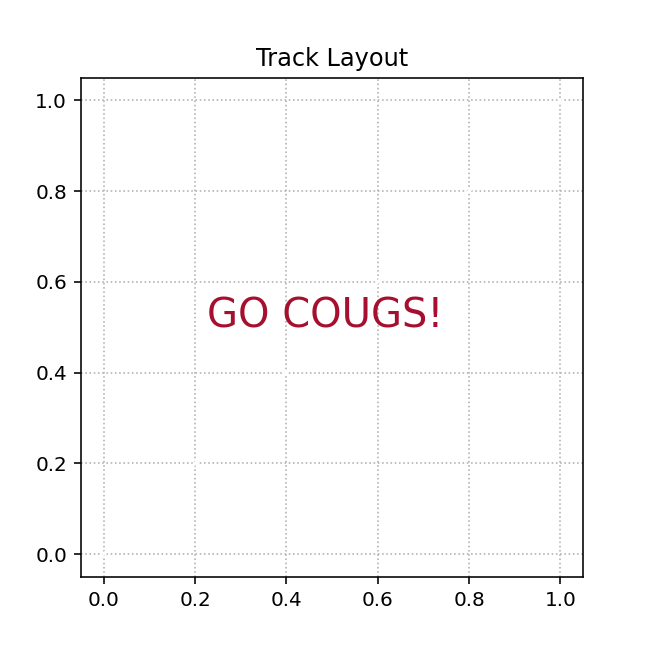

In [19]:
JSP

In [21]:
#JSP.show() #Use if you want to run in a separate window

### Manual Mode of Saving Files

In [22]:
ls

BottomGuard.png*                      TopGuard.png*
SLIM Pickens GUI v2.ipynb*            TurnLayout.png*
SLIM Pickins v2--Manual Layout.ipynb* boardLayout.json*


In [23]:
pcbDictMain, retStr = cleanSLIMDict(JSP.moveDict, boardInfo = 'Test SLIM')

Type and Number of Footprints Needed BEFORE running script in KiCad (* is the footprint number):\n	TW1GT*: 2\n	TW1GB*: 2


In [24]:
sortedPCBDictMain = flipPCBDict(pcbDictMain)

In [25]:
outputName = 'exampleSLIM.json'
dumpJSON(outputName, sortedPCBDictMain)

Done Writing exampleSLIM.json to disk
